In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
## STEPS:
#1. Load model
#2. load data
#3. Run inference on 1 sample
#4. Make a wrapper for using scikit learn
#5. Run inference on 1 sample using wrapper
#6. Run shap values using 1 example

In [13]:
#!pip install lightning
#!pip install git+https://github.com/wfondrie/depthcharge.git
#!pip install --force-reinstall lance
#!pip install shap

In [14]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [15]:
ls ../data/

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
drug_plus.mgf
hr_msms_nist_all.MSP*
hr_msms_nist_sample.MSP
merged_gnps_nist_20240118_gnps_nist_janssen.pkl
merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl
ms2deepscore_positive_10k_1000_1000_1000_500.hdf5
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.trainables.syn1neg.npy
spec2vec_AllPositive_ratio05_filtered_201101_iter_15.model.wv.vectors.npy
to_export_gnps_nist.pkl
uniformed_molecule_pairs_test.pkl


python(35696) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


In [16]:
## Params
dataset_path = '../data/merged_gnps_nist_20240207_gnps_nist_janssen_15_millions.pkl'
#best_model_path='../data/best_model_128n_10_layers_20240209.ckpt'
best_model_path='../data/best_model_128n_5_layers_20240229.ckpt'

In [17]:
import shap
import matplotlib.pyplot as plt
from src.transformers.embedder import Embedder
from src.config import Config
import dill
from src.train_utils import TrainUtils
from src.transformers.load_data import LoadData
from src.molecular_pairs_set import MolecularPairsSet
from torch.utils.data import DataLoader
import lightning.pytorch as pl
from src.transformers.postprocessing import Postprocessing
import numpy as np
from src.transformers.sklearn_model import SklearnModel
import spectrum_utils.plot as sup

In [18]:
config=Config()

In [19]:
# 1. load model
best_model = Embedder.load_from_checkpoint(best_model_path, d_model=int(config.D_MODEL), n_layers=int(config.N_LAYERS))

In [20]:
best_model

Embedder(
  (linear): Linear(in_features=128, out_features=128, bias=True)
  (linear_regression): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
  (spectrum_encoder): SpectrumTransformerEncoderCustom(
    (peak_encoder): PeakEncoder(
      (mz_encoder): FloatEncoder()
      (int_encoder): FloatEncoder()
      (combiner): Linear(in_features=256, out_features=128, bias=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-4): 5 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=1024, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=1024, out_features=128, bias=True)
          (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((128,), eps=1e-05

## load data

In [21]:
# load data
# Load the dataset from the pickle file
with open(dataset_path, 'rb') as file:
    dataset = dill.load(file)

molecule_pairs_train = dataset['molecule_pairs_train']
molecule_pairs_val = dataset['molecule_pairs_val']
molecule_pairs_test= dataset['molecule_pairs_test']
uniformed_molecule_pairs_test = dataset['uniformed_molecule_pairs_test']

<Axes: xlabel='m/z', ylabel='Intensity'>

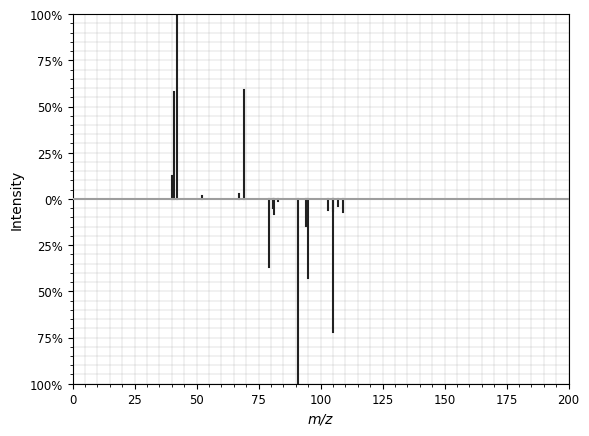

In [22]:
#plot one spectrum from molecule_pairs_test

sup.mirror(uniformed_molecule_pairs_test[0].spectrum_object_0, uniformed_molecule_pairs_test[0].spectrum_object_1)

In [23]:
len(uniformed_molecule_pairs_test)

185165

In [24]:
index = 0

In [25]:
one_molecule_pair  = MolecularPairsSet(spectrums=uniformed_molecule_pairs_test.spectrums, 
                                       indexes_tani = uniformed_molecule_pairs_test.indexes_tani[index:index+1,:])

In [26]:
one_molecule_pair

## Make a wrapper

In [27]:
sklearn_model = SklearnModel(best_model_path, d_model=int(config.D_MODEL), n_layers=int(config.N_LAYERS))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [68]:
explainer=sklearn_model.get_explainer(uniformed_molecule_pairs_test)

Preprocessing all the data ...


32486it [00:00, 76568.41it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries
Preprocessing all the data ...


32486it [00:00, 77223.68it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries
Prediction has been called


Predicting: |                                                                                                 …

## Target molecule pair

In [29]:
mol_gnps = uniformed_molecule_pairs_test.get_gnps_pairs()
mol_gnps = mol_gnps.filter_by_similarity(min_sim=1, max_sim=1)

In [30]:
len(mol_gnps)

274

In [31]:
index_gnps=1

In [32]:
print(mol_gnps[index_gnps])

Molecular pair with similarity: 1.0 for smiles_0: CCN(CC)CCOC(=O)C1=CC=C(C=C1)N and smiles_1: CCN(CC)CCOC(=O)C1=CC=C(N)C=C1


In [33]:
mol_gnps[index_gnps].spectrum_object_0.params['spectrumid'],mol_gnps[index_gnps].spectrum_object_1.params['spectrumid']

('CCMSLIB00000567489', 'CCMSLIB00005744304')

<Axes: xlabel='m/z', ylabel='Intensity'>

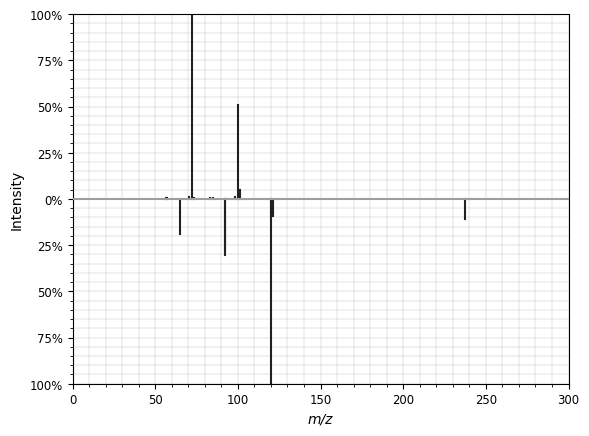

In [34]:
sup.mirror(mol_gnps[index_gnps].spectrum_object_0, mol_gnps[index_gnps].spectrum_object_1)

In [35]:
target_molecule_pair  = MolecularPairsSet(spectrums=mol_gnps.spectrums, 
                                      indexes_tani = mol_gnps.indexes_tani[index_gnps:index_gnps+1,:])

In [36]:
target_molecule_pair.indexes_tani

array([[9.4000e+01, 1.1143e+04, 1.0000e+00]])

## Compute shap

In [70]:
shap_values, X = sklearn_model.compute_shap_values(explainer, target_molecule_pair)

Preprocessing all the data ...


32486it [00:00, 77091.20it/s]

Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


  0%|          | 0/1 [00:00<?, ?it/s]

Prediction has been called


Predicting: |                                                                                                 …

Prediction has been called


Predicting: |                                                                                                 …

In [37]:
shap_values, X = sklearn_model.compute_shap_values(explainer, target_molecule_pair)

Preprocessing all the data ...


32486it [00:00, 80427.78it/s]


Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries
Prediction has been called


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
The operator 'aten::_nested_tensor_from_mask_left_aligned' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)


Prediction has been called


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Prediction has been called


Predicting: |                                                                                                 …

Prediction has been called


Predicting: |                                                                                                 …

Prediction has been called


Predicting: |                                                                                                 …

PermutationExplainer explainer: 2it [02:47, 167.15s/it]                                                                                                                                                             


In [69]:
shap_interaction_values = explainer.shap_interaction_values(X)

AttributeError: 'KernelExplainer' object has no attribute 'shap_interaction_values'

In [ ]:
shap.summary_plot(shap_interaction_values, X)

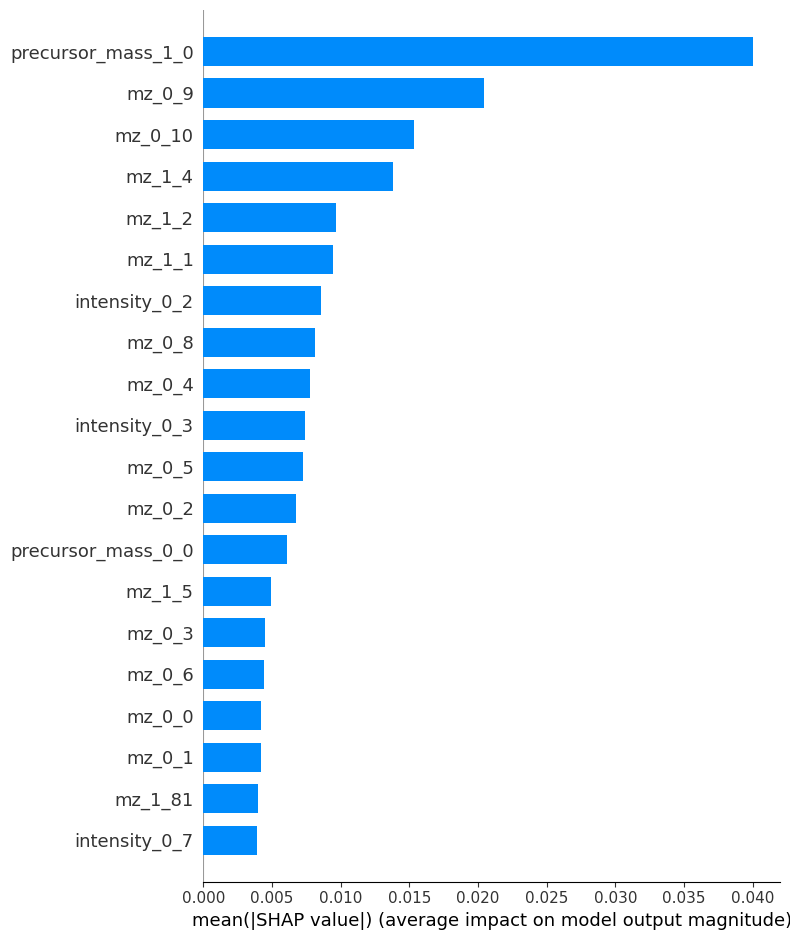

In [71]:
# Plot the SHAP summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

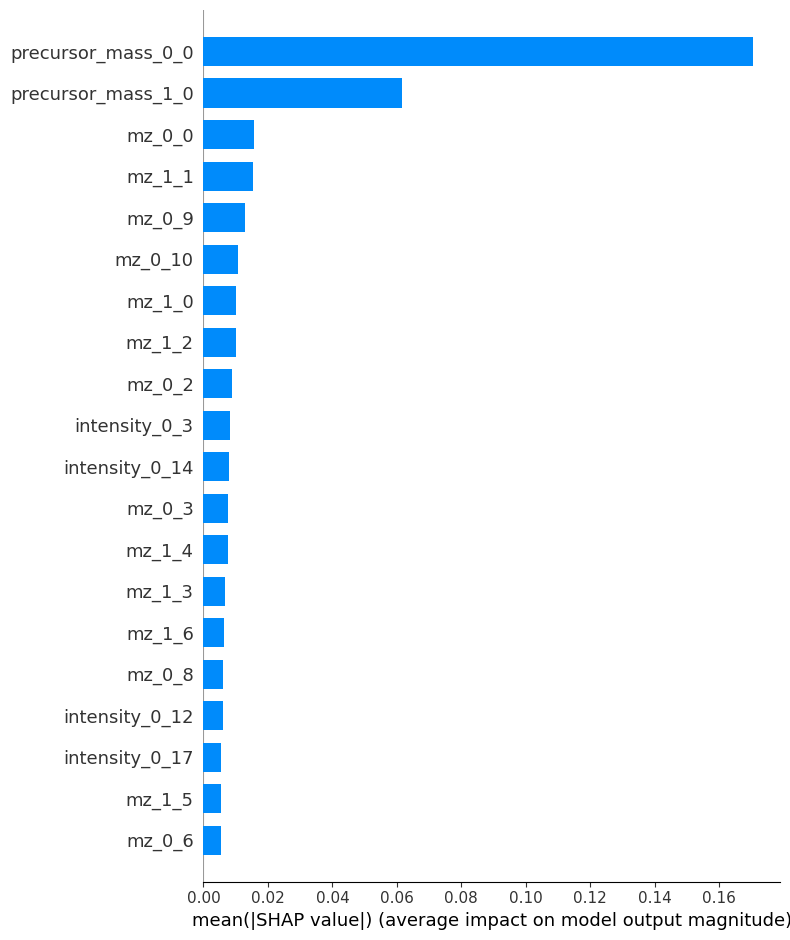

In [38]:
# Plot the SHAP summary plot
shap.summary_plot(shap_values, X, plot_type="bar")

In [39]:
spectrum_0 = target_molecule_pair.spectrums[int(target_molecule_pair.indexes_tani[0,0])]

In [40]:
spectrum_1 = target_molecule_pair.spectrums[int(target_molecule_pair.indexes_tani[0,1])]

In [41]:
len(spectrum_0.mz)

12

<Axes: xlabel='m/z', ylabel='Intensity'>

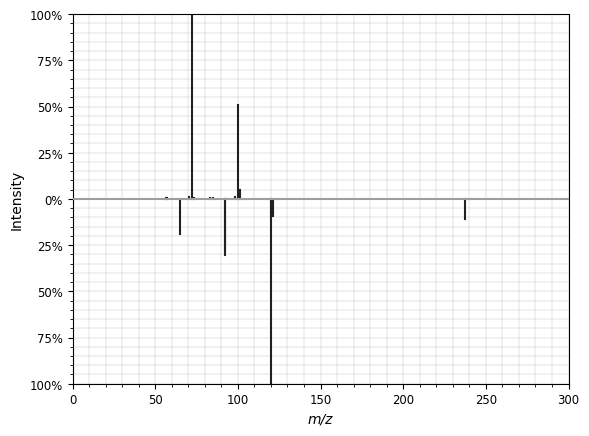

In [42]:
import spectrum_utils.plot as sup
sup.mirror(spectrum_0, spectrum_1)

In [43]:
len(spectrum_0.mz), len(spectrum_1.mz)

(12, 7)

In [44]:
def plot_peaks(mz, intensity, mark_indexes=[], xmin=0, xmax=1000):
    plt.scatter(mz, intensity)
    
    for x,y in zip(mz, intensity):
        plt.vlines(x=x, ymin=0, ymax=y, color='g', linestyle=':', label='Vertical Line at x=4, y=4')
    for m in mark_indexes:
        plt.scatter(mz[m], intensity[m], marker='x', color='red', s=100)

    plt.xlim([xmin, xmax])
    plt.xlabel('mz')
    plt.ylabel('intensity')
    plt.grid()

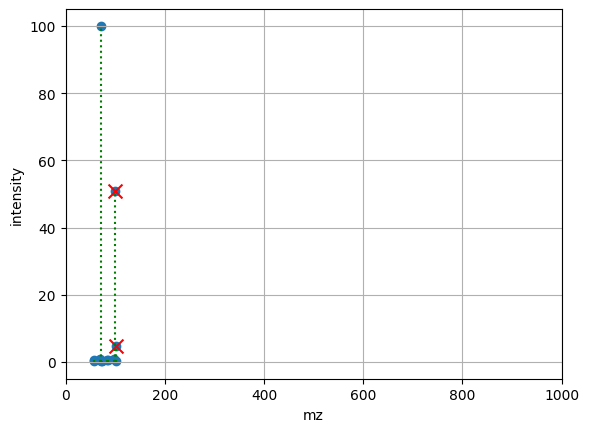

In [45]:
plot_peaks(spectrum_0.mz, spectrum_0.intensity, mark_indexes=[9,10])

In [46]:
for mz, intensity in zip(spectrum_0.mz,spectrum_0.intensity):
    print(mz, intensity)

56.3 0.599305
57.2 0.403093
70.2 0.888289
71.2 0.189254
72.2 100.0
73.2 0.256978
83.2 0.474527
85.1 0.624353
98.0 0.898958
100.1 50.89455
101.1 4.645079
102.3 0.174875


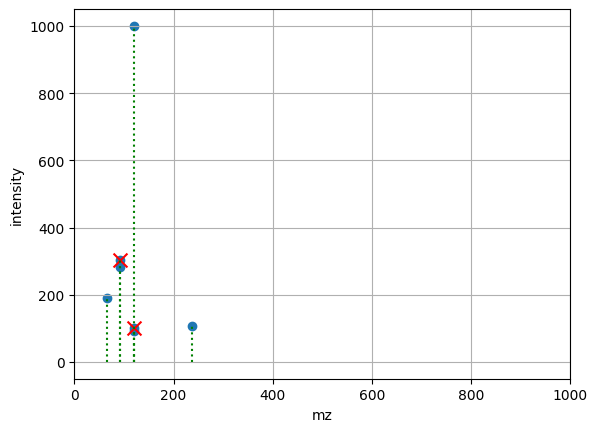

In [47]:
plot_peaks(spectrum_1.mz, spectrum_1.intensity, mark_indexes=[2,3])

In [48]:
spectrum_0.params

{'pepmass': (100.0, None),
 'charge': [1],
 'mslevel': '2',
 'source_instrument': 'LC-ESI-Ion Trap',
 'filename': 'output_mgf.mgf',
 'seq': '*..*',
 'ionmode': 'Positive',
 'organism': 'MONA',
 'name': 'MoNA:2475814 Anticort M+H',
 'pi': 'MoNA',
 'datacollector': 'MoNA',
 'smiles': 'CCN(CC)CCOC(=O)C1=CC=C(C=C1)N',
 'inchi': 'InChI=1S/C13H20N2O2/c1-3-15(4-2)9-10-17-13(16)11-5-7-12(14)8-6-11/h5-8H,3-4,9-10,14H2,1-2H3',
 'inchiaux': 'N/A',
 'pubmed': 'N/A',
 'submituser': 'mwang87',
 'libraryquality': '3',
 'spectrumid': 'CCMSLIB00000567489',
 'scans': '4740'}

## checkl for previous shown molecule

In [49]:
spectrum_id_0 = 'CCMSLIB00009918486'
spectrum_id_1 = 'CCMSLIB00009919212'

In [50]:
spectrums_total = molecule_pairs_train.spectrums + molecule_pairs_val.spectrums + molecule_pairs_test.spectrums

In [51]:
spectrumids = [s.params['spectrumid']  if 'spectrumid' in s.params.keys() else None for s in spectrums_total]


In [52]:
spectrum_index_0=spectrumids.index(spectrum_id_0)

In [53]:
spectrum_index_1 = spectrumids.index(spectrum_id_1)

In [54]:
spectrum_0= spectrums_total[spectrum_index_0]
spectrum_1=spectrums_total[spectrum_index_1]

<Axes: xlabel='m/z', ylabel='Intensity'>

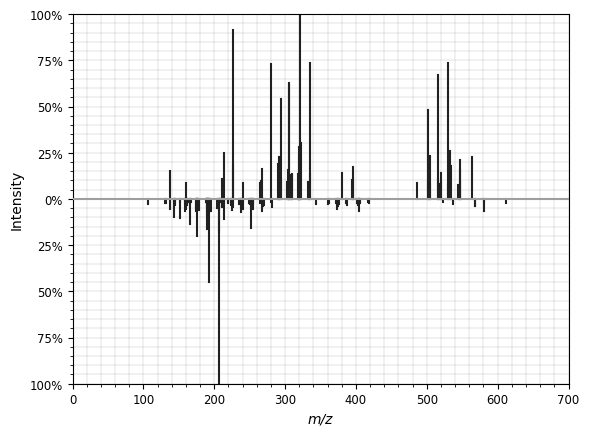

In [55]:
import spectrum_utils.plot as sup
sup.mirror(spectrum_0, 
           spectrum_1)

In [56]:
target_pair = MolecularPairsSet(spectrums= [spectrum_0, spectrum_1 ],
                                indexes_tani = np.array([[0,1,1]]))

In [57]:
shap_values, X = sklearn_model.compute_shap_values(explainer, target_pair)

Preprocessing all the data ...


2it [00:00, 11949.58it/s]

Finished preprocessing 
Starting the loading of the data ...
Normalizing intensities
Creating dictionaries


Prediction has been called


/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Prediction has been called


Predicting: |                                                                                                 …

Prediction has been called


Predicting: |                                                                                                 …

Prediction has been called


Predicting: |                                                                                                 …

/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...

KeyboardInterrupt



In [ ]:
shap.summary_plot(shap_values, X,plot_type="bar")

In [ ]:
spectrum_0.mz[3],spectrum_0.mz[31]

In [ ]:
spectrum_1.mz[13]

In [ ]:
plot_peaks(spectrum_0.mz, spectrum_0.intensity, mark_indexes=[3,31])

In [ ]:
plot_peaks(spectrum_1.mz, spectrum_1.intensity, mark_indexes=[21])

In [ ]:
spectrum_0.params

In [ ]:
spectrum_1.params

In [ ]:
target_pair.spectrums

In [ ]:
target_pair.indexes_tani

In [ ]:
sklearn_model.predict_from_molecule_pair(target_pair)